In [1]:
import sys
sys.path.append('../utils/')

In [2]:
from ImageUtils import *

In [3]:
import numpy as np
import pandas as pd # Needs the package Pandas to be installed. Check Anaconda Environments and Packages.
from sklearn.decomposition import PCA # Needs SciKit Learn package to be installed. Check Anaconda Environments and Packages.4
from sklearn.covariance import LedoitWolf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
from collections import Counter
from sklearn.preprocessing import label_binarize
import time
from sklearn import preprocessing
import ipywidgets as widgets
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

In [4]:
faces94_male = readFaces94MaleFaces(gray=True)
faces94_female = readFaces94FemaleFaces(gray=True)
faces94_malestaff = readFaces94MaleStaffFaces(gray=True)
landscapes = np.array(readLandsCapeImage(gray=True))

dataset = np.vstack((faces94_male, faces94_female, faces94_malestaff, landscapes))

dataset_N, height, width = dataset.shape
dataset.shape

(3269, 200, 180)

## Data centralization and calculate of covariance matrix

In [ ]:
A=dataset.reshape(dataset_N, height*width)/255 # normalización para reducir complejidad

In [ ]:
dist_1=[]
start_time = time.time()
for i in range(A.shape[0]):
    d = np.linalg.norm(np.subtract(A[i], A), ord=2, axis=1)
    s=np.sum(np.sum(d,axis=0)) # suma de las difenrecias
    dist_1.append(s) # Guardando la suma de las diferencias de la imagen i a las demas

total_time = time.time() - start_time

print("Time elapsed for operation: {}".format(total_time))

In [ ]:
Min_1=np.argmin(np.array(dist_1))

In [ ]:
plt.imshow(dataset[Min_1],plt.cm.gray)

In [ ]:
Min_1 #Median image index: 394 (including male, female, malestaff and landscapes)
      #Median image index: 393 (including only male, female and malestaff)

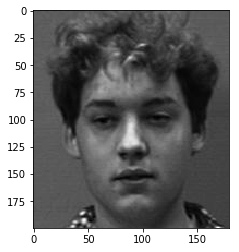

In [5]:
plt.imshow(dataset[394],plt.cm.gray)

In [6]:
Median_all = dataset[394]

In [7]:
data=dataset.reshape(dataset_N, height*width) - Median_all.reshape(height*width)
datasetmedian=(1/(dataset_N-1))*(np.dot(data,data.T)) # Covariance matrix
print(datasetmedian.shape)

(3269, 3269)


### Singular value decomposition

In [8]:
u,s,vh = np.linalg.svd(datasetmedian)

### Face space: selection of subspace componets

#### Option 1: investigator's criteria of varibility captured

In [9]:
representation_percentage = 0.85 # Selected variability 

In [10]:
sum_eig = np.sum(s)
percentage_variance = np.divide(s, sum_eig)
sum_var = 0
num_var = 0
for i in np.arange(percentage_variance.shape[0]):
    if sum_var >= representation_percentage:
        num_var = i
        break;
    
    sum_var += percentage_variance[i]
    
num_var_select=num_var    
print("Principal components number: ",num_var_select)
print("Percent of variability captured: ",sum_var*100)
print("Images in datasets",dataset_N)

Principal components number:  39
Percent of variability captured:  85.08884129114449
Images in datasets 3269


#### Option 2: investigator's criteria of threshold contribution value

First 348 components with  97.39420413970947 percent of variability captured and from which the contribution is less than 0.01%


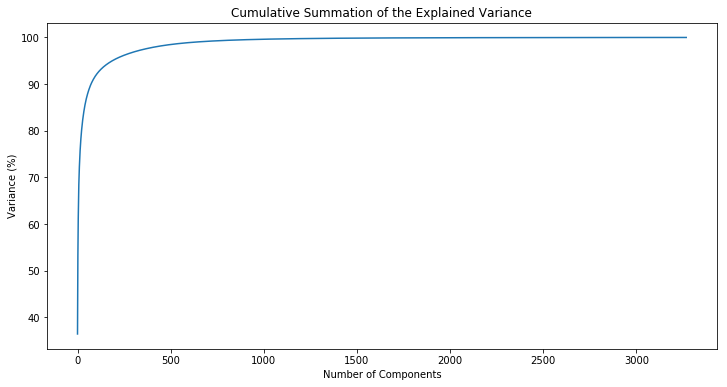

In [11]:
cum_per=np.cumsum(percentage_variance)
for i in range(1,len(s)):
    change=(cum_per[i]-cum_per[i-1])/cum_per[i-1]*100
    if(change<.01):
        num_var=i-1
        print("First",num_var, "components with ",cum_per[num_var]*100,"percent of variability captured and from which the contribution is less than 0.01%")
        break

plt.figure(figsize=(12,6))
plt.plot(cum_per*100)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Cumulative Summation of the Explained Variance')
plt.show()

## Face Space

In [12]:
EigenvectorsA=np.dot(data.T,u[:,0:num_var_select])
NormEigenvectorsA = preprocessing.normalize(EigenvectorsA,axis=0, norm='l2')
print(np.linalg.norm(NormEigenvectorsA[:,5],ord=None))#check normalizacion vectores propios de XT.X

0.9999989


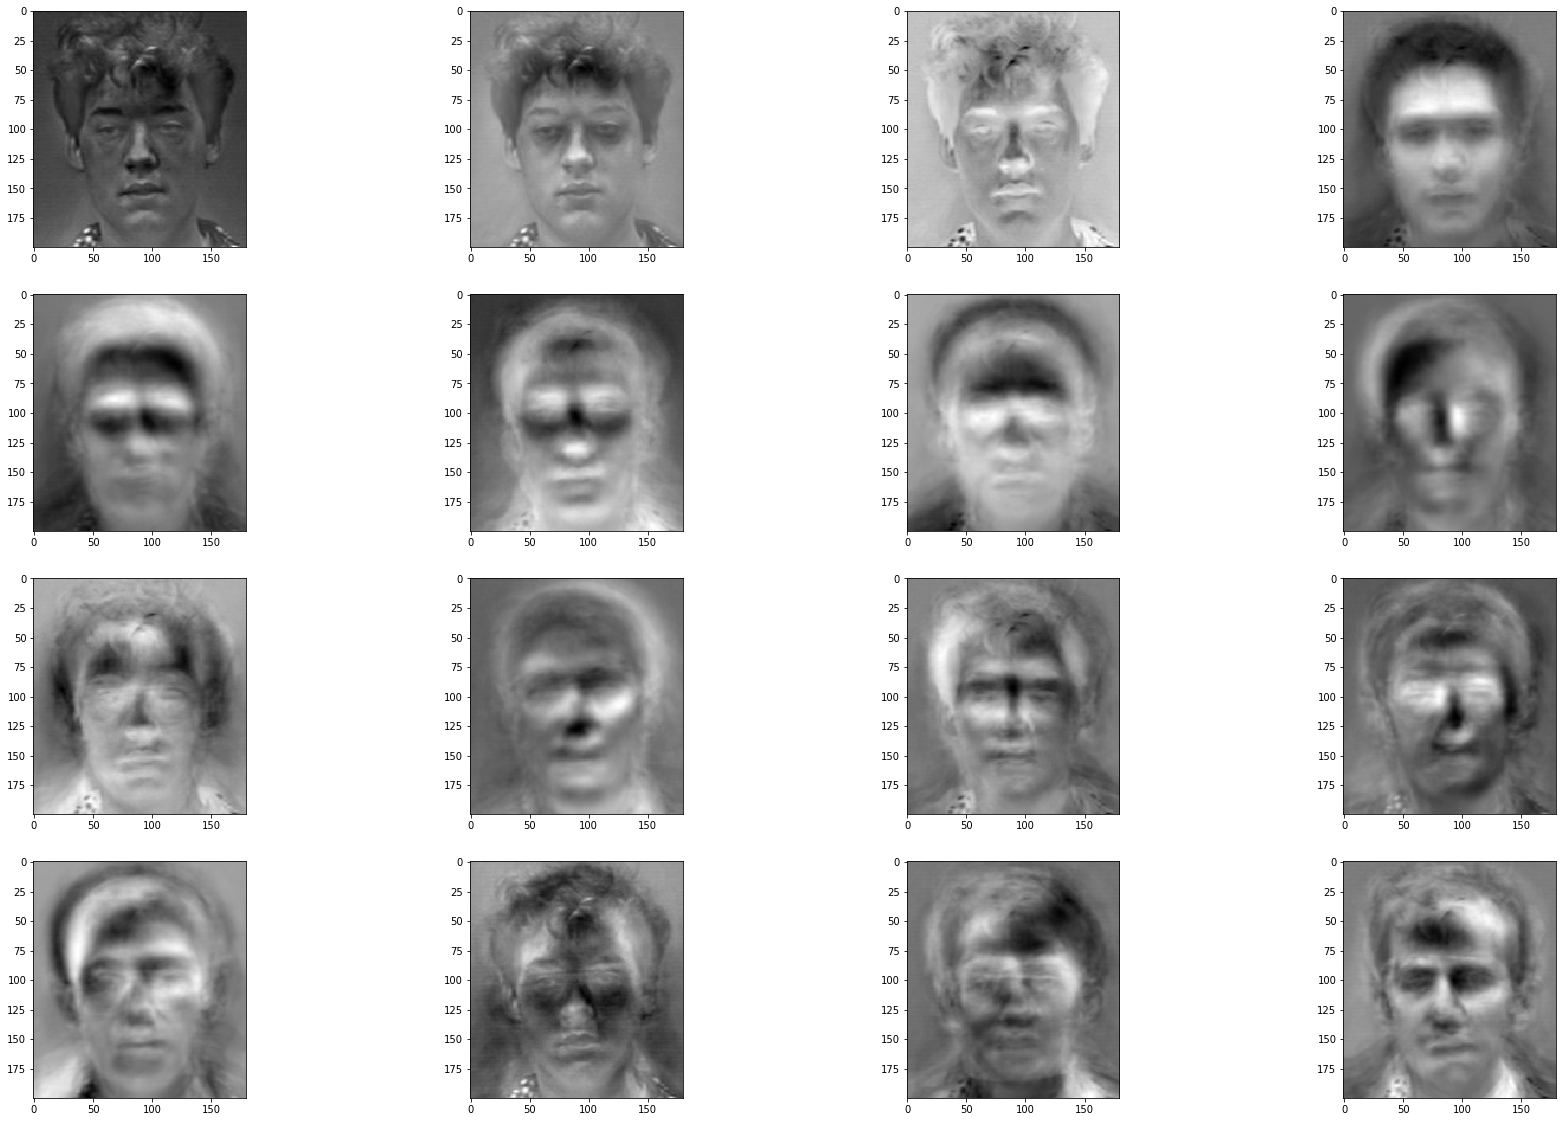

In [13]:
cols = 4
rows = 4
plt.figure(figsize=(30,20))
for i in np.arange(rows * cols):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(NormEigenvectorsA[:,i].reshape(height, width), plt.cm.gray)

## Projection of an image on face space

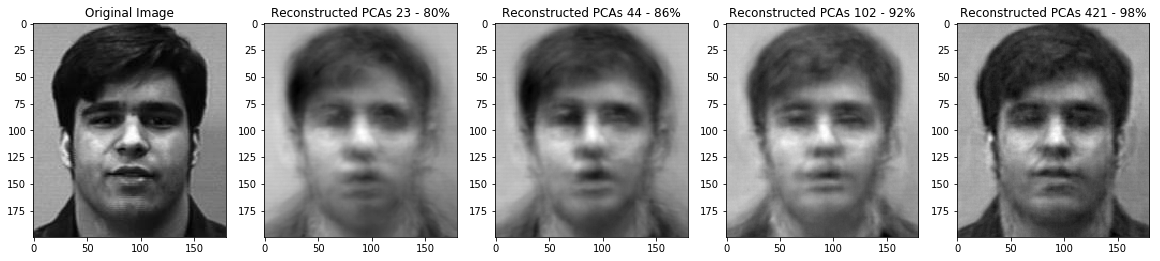

In [14]:
start=0.8
step=0.06
stop=1

facespace(percentage_variance,dataset,data,Median_all,u,dataset_N,height,width,start,step,stop,0)

In [15]:
print("Principal components number: ",num_var_select)
print("Percent of variability captured: ",sum_var*100)
print("Images in datasets",dataset_N)
print("Omega matrix facespace",np.dot(data,NormEigenvectorsA).shape)

Principal components number:  39
Percent of variability captured:  85.08884129114449
Images in datasets 3269
Omega matrix facespace (3269, 39)


### Specific image

In [16]:
import ipywidgets as widgets
n=widgets.BoundedFloatText(value=2690,min=0,max=dataset_N,description='image:')
display(n)

BoundedFloatText(value=2690.0, description='image:', max=3269.0)

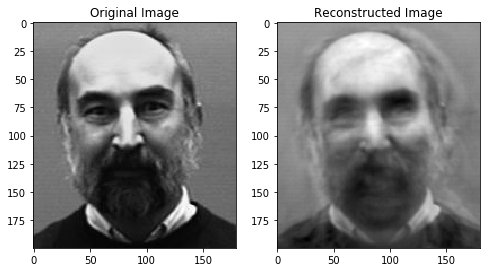

In [17]:
N_image=int(n.value)
specificimage(data,dataset,NormEigenvectorsA,Median_all,N_image,dataset_N,height,width)

### Random image

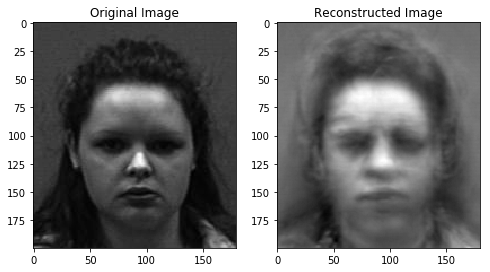

In [18]:
randomimage(data,dataset,NormEigenvectorsA,Median_all,dataset_N,height,width)

### Distances and outliers

In [19]:
dataReconstructed=np.dot(np.dot(data,NormEigenvectorsA),NormEigenvectorsA.T)+Median_all.reshape(height*width)
print(dataReconstructed.shape)

(3269, 36000)


In [20]:
Norm=widgets.Dropdown(options=['1', '2', 'inf'],value='2',description='Norm:',disabled=False)
display(Norm)

Dropdown(description='Norm:', index=1, options=('1', '2', 'inf'), value='2')

In [21]:
if str(Norm.value)=='inf':
    ordn=np.inf
else:
    ordn=int(Norm.value)

In [22]:
edistance = np.linalg.norm(np.subtract(dataReconstructed, dataset.reshape(dataset_N, height*width)), ord=ordn, axis=1)
print(edistance.shape)

(3269,)


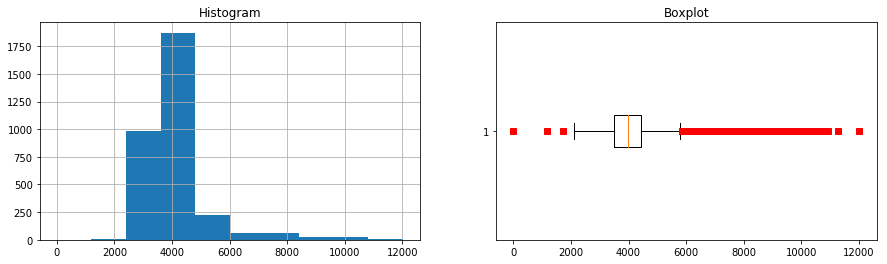

In [23]:
histbox(edistance)

In [24]:
threshold, outliers, zsort, indexsort, z=outlierseigenfaces(edistance,3)

print('Outliers threshold method=',np.size(outliers))
print('threshold=',threshold)
CVresult={'outliers distance':outliers,'z':zsort}
df = pd.DataFrame(CVresult)
df.sort_values('z', axis = 0, ascending = False, inplace = True, na_position ='first') 
df.head(np.size(outliers)) 

Outliers threshold method= 98
threshold= 3


,outliers distance,z
97,12020.844727,6.866884
96,11271.159180,6.215954
95,10938.583984,5.927189
94,10911.661133,5.903812
93,10749.055664,5.762627
92,10698.971680,5.719141
91,10650.583008,5.677126
90,10623.394531,5.653519
89,10469.293945,5.519718
88,10468.677734,5.519183


#### Low and high distance

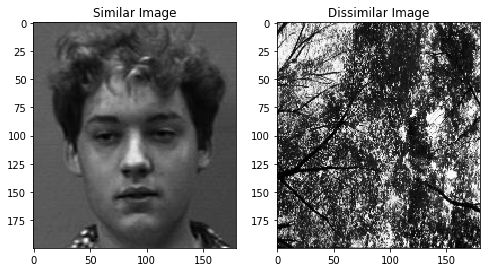

In [25]:
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(1,2,1)
plt.title("Similar Image")
ax1.imshow(dataset[indexsort[0]], plt.cm.gray)
ax2 = fig.add_subplot(1,2,2)
plt.title("Dissimilar Image")
ax2.imshow(dataset[indexsort[-1]], plt.cm.gray)

#### High distances

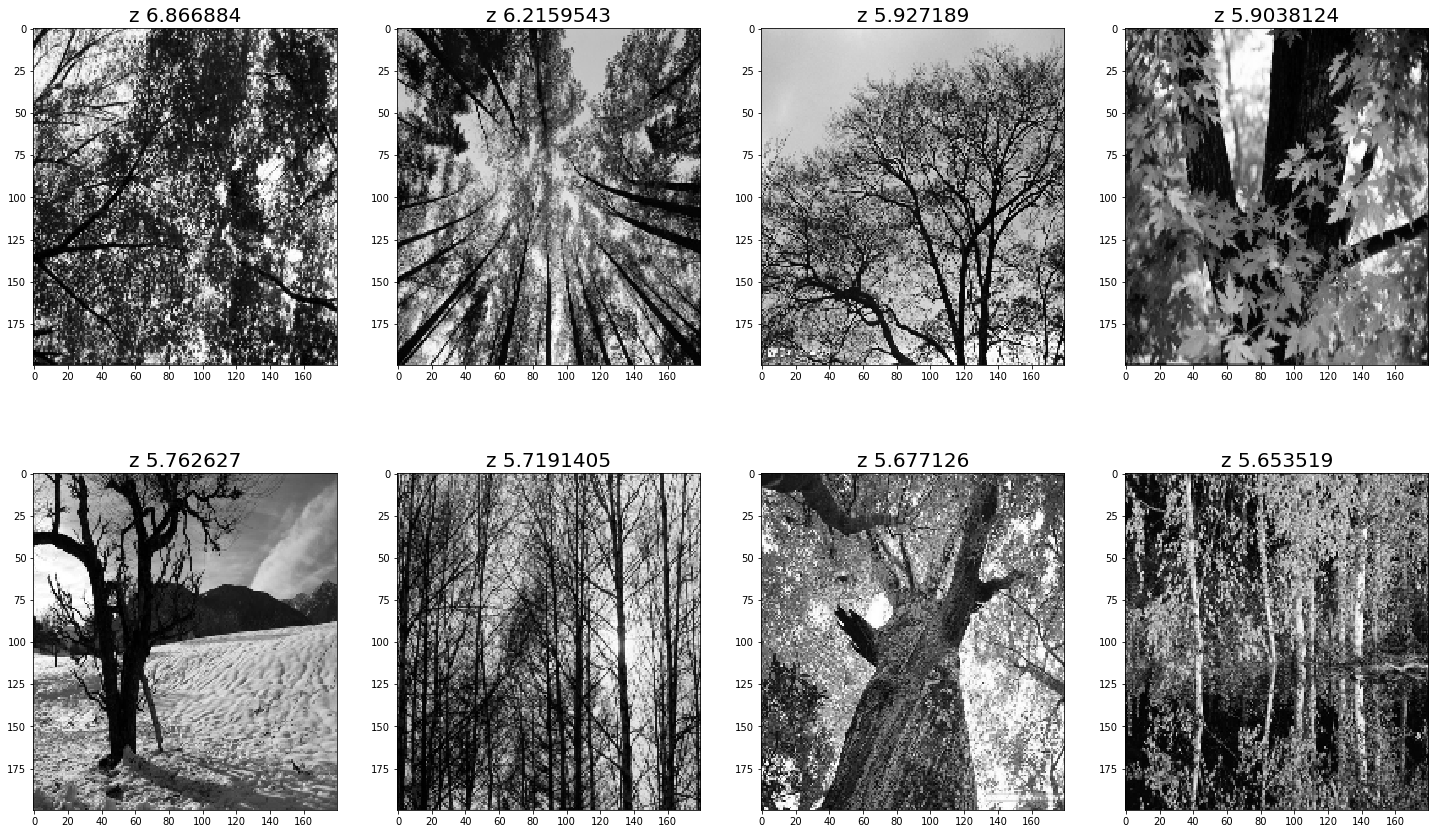

In [26]:
cols = 4
rows = 2
plt.figure(figsize=(25,15))
for i in np.arange(rows * cols):
    plt.subplot(rows, cols, i + 1)
    plt.title("z "+str(z[indexsort[-(i+1)]]),fontsize=20)
    plt.imshow(dataset[indexsort[-(i+1)]], plt.cm.gray)

## Face recognition dataset

No pertenece al dataset
4915.826


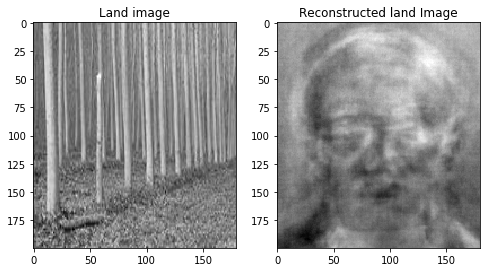

In [27]:
landscapes = np.array(readLandsCapeImage(gray=True))

landimages(landscapes,height,width,Median_all,NormEigenvectorsA,ordn,outliers)

(210, 36000)


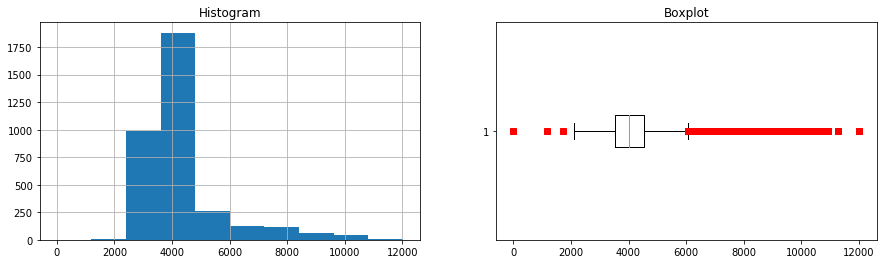

In [28]:
landimage=landscapes.reshape(landscapes.shape[0],height*width)-Median_all.reshape(height*width)
dataReconstructedland=np.dot(np.dot(landimage,NormEigenvectorsA),NormEigenvectorsA.T)+Median_all.reshape(height*width)
print(dataReconstructedland.shape)

edistanceland = np.linalg.norm(np.subtract(dataReconstructedland, landscapes.reshape(landscapes.shape[0], height*width)), ord=ordn, axis=1)
totaldistance=np.append(edistance,edistanceland)
histbox(totaldistance)

TP= 1 TN= 210 FP= 0 FN= 3268
accuracy=  0.06064961195745904


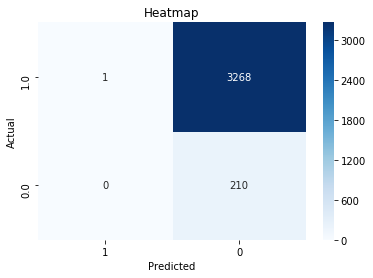

In [29]:
y_true=np.ones(dataset_N)
y_true=np.append(y_true,np.zeros(landscapes.shape[0]))
y_pred=(totaldistance<=outliers[0])*1

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print('TP=', tp,'TN=',tn,'FP=',fp,'FN=', fn)
print('accuracy= ', (tp+tn)/(tp+tn+fp+fn))

plt.figure()
plt.title("Heatmap")
prediction_data = {'y_Actual': y_true,'y_Predicted': y_pred}
df = pd.DataFrame(prediction_data, columns=['y_Actual','y_Predicted'])
confusionmatrix1 = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
ax=sns.heatmap(confusionmatrix1, annot=True,cmap='Blues', fmt='.0f');
ax.invert_yaxis()
ax.invert_xaxis()

#### False positive

In [30]:
for outlier in outliers:
    print(np.where(outlier > edistanceland))

(array([], dtype=int64),)
(array([  0,   3,   4,   6,   7,  10,  19,  20,  27,  28,  30,  31,  32,
        33,  35,  37,  38,  39,  40,  41,  44,  45,  50,  52,  53,  54,
        55,  57,  58,  59,  64,  67,  69,  71,  72,  75,  76,  77,  78,
        79,  83,  86,  87,  89,  91,  93,  95,  98,  99, 100, 101, 108,
       110, 111, 112, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 135, 136, 138, 140, 142, 143, 147, 148,
       152, 154, 157, 159, 162, 163, 164, 165, 170, 172, 173, 176, 178,
       180, 181, 184, 185, 186, 187, 190, 191, 192, 193, 194, 195, 196,
       197, 198, 199, 202, 203, 204, 205, 206, 208], dtype=int64),)
(array([  0,   3,   4,   6,   7,  10,  19,  20,  27,  28,  30,  31,  32,
        33,  35,  37,  38,  39,  40,  41,  44,  45,  50,  52,  53,  54,
        55,  57,  58,  59,  64,  67,  69,  71,  72,  75,  76,  77,  78,
        79,  83,  86,  87,  89,  91,  93,  95,  98,  99, 100, 101, 108,
       110, 111, 112, 115, 116, 117, 118

distancia 6554.1143


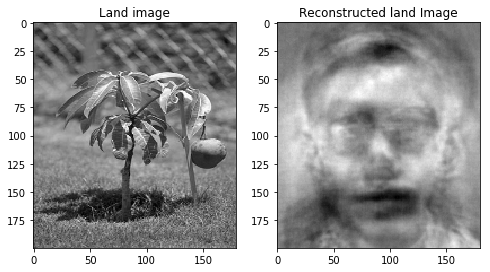

In [31]:
N_land= int(np.where(edistanceland < outliers[6])[0][3])
landimage=landscapes[N_land].reshape(height*width)-Median_all.reshape(height*width)#seleccionar imagen individual
wland=np.dot(landimage,NormEigenvectorsA)#pesos w de cada Eigenface en subespacio generado
Reconstland=np.dot(wland,NormEigenvectorsA.T)+Median_all.reshape(height*width)#es mas claro w*vectores propios transpuestos
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(1,2,1)
plt.title("Land image")
ax1.imshow(landscapes[N_land], plt.cm.gray)
ax2 = fig.add_subplot(1,2,2)
plt.title("Reconstructed land Image")
ax2.imshow(Reconstland.reshape(height, width), plt.cm.gray)
print('distancia',edistanceland[N_land])

In [32]:
accuracy, tncv, fpcv, fncv, tpcv=kfold(y_true,landscapes,dataset,height,width,ordn)
CVresult={'accuracy':accuracy,'tn':tncv,'fp':fpcv,'fn':fncv,'tp':tpcv}
df = pd.DataFrame(CVresult)
df.head()   

KFold(n_splits=5, random_state=42, shuffle=True)
test:  863
faces:  653
landscapes:  210


,accuracy,tn,fp,fn,tp
0,0.756944,0.0,210.0,0.0,654.0
1,0.756944,1.0,209.0,1.0,653.0
2,0.756944,0.0,210.0,0.0,654.0
3,0.756944,0.0,210.0,0.0,654.0
4,0.756663,0.0,210.0,0.0,653.0
